# CitiBike 
## Part 2: Identifying Removals from Service

### Overview
The Citi Bike system is a bicycle ride sharing system based in New York City where users can rent bikes for short periods of time. Users pick up a bike at a station, and ride to another station where they drop the bike off. The bikes are used for commuting, sight seeing, and general travelling throughout the city.

Part 2 is focused on identifying bikes which have been removed from service. The primary purpose of this is to help better understand how many bikes are at a station at a given time. To do this we need to understand everytime a bike is added or removed. Sometimes bikes are removed from maintenance, but we don't have any data for these removals.

<img src="service.jpg" width=600 height=400 />

### Approach
My approach is to infer a bike has been removed if it has been at the station without being used for a long period of time. If the bike was removed, then it would not be available for customers to select, and it would remain at the station.

Note: Another reason the bike wasn't selected, would be that the bike is be broken. Thus Citi Bike could use their customer behavior data to inform them when a bike is broken.

They key of this approach is to determine how long to wait before getting suspicious that the bike isn't at the station any more. 1 day? 1 week? 1 month?

While a time-based approach would be okay, a better way would be to base it off the number of times a bike was not selected from a given station. Each time a customer picks a bike from a station, each bike has a chance of being selected. Each time the bike is not selected, a customer has decided not to use the bike. Each time the significance of the bike not being selected grows.

In addition, the number of bikes the customer has to choose from is also important. For instance if there were 30 bikes at a station, it is fairly unlikely that any one bike would selected, and thus the weight of the customer's decision is small. However, if there are only 2 or 3 bikes available, then the signficance of the customer not choosing this bike is higher.

The assumptions made here are that every bike has an equally likely chance of being selected. This is likely a false assumption. Customers may select bikes near the sides of the station more often than the middle since customers usually approach the stations from the sides and they would likely pick bike the closest bike. However, we don't have information about where the bikes are docked within a given station. This could be accommodated by choosing a high threshold for determining what is a significant result.

Which bike would you choose?

<img src="citi_bike_station.jpg" width=600/>



In [1]:
import pandas as pd
import numpy as np
import os
import stat
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt
import data_processing

### Read Trips Data

I start by importing the May 2020 trips dataset.

In [10]:
folder = os.getcwd()
zip_file = '/202005-citibike-tripdata.csv.zip'
zip_file_path = folder + zip_file
trips = data_processing.process_monthly_trips(zip_file_path)

stations = pd.read_csv(folder + '/station_feed_06-24-20.csv')

In [11]:
# Process ops data
ops = data_processing.convert_trips_to_ops(trips)
ops = data_processing.fill_missing_ops(trips, ops)
ops = data_processing.insert_status_updates(stations, ops)

# Calculate the new number of starting bikes
ops['sum_net_bikes'] = ops.groupby('station_id')['net_bikes'].cumsum()
offset = ops[ops.op_type=='status'][['station_id', 'available_bikes', 'sum_net_bikes']].copy()
offset['starting_bikes'] = offset['available_bikes'] - offset['sum_net_bikes']

In [12]:
# Merge the number of total docks
offset = offset.merge(stations[['id', 'totalDocks']], how='left', left_on='station_id', right_on='id')

# Get the percent of invalid starting bikes available
print('Percent of invalid starting bikes %.2f ' % (100*np.mean((offset.starting_bikes < 0) | (offset.starting_bikes > offset.totalDocks))))

Percent of invalid starting bikes 4.73 


The data shows that 4.73% stations do not fufill a valid starting criteria. This means that our data augmentation significantly improved our station data, but was not a complete solution. 

This is where our solution of finding removed bikes will come in

### Identify Removed Bikes
There are over 3 million operations, and about 1.5 million of them are departures. At each departure we need to change information for the other Citi Bikes located at the station the bike was removed from. With so many operations, the solution needs to be efficient and run quickly.

A solution to this challenge is to create objects which track information about bikes, most specifically measures of how long it has been since a bike has been selected. To do this efficiently, a CitiBike class is defined.

In addition, the specific bikes at each station needs to be tracked. This information is tracked using a Station class.

This object oriented approach in Python will be much easier to write, and will iterate much faster than trying to implement in Pandas.

In [13]:
class CitiBike(object):
    def __init__(self, id, location, last_drop_off_time):
        self.id = id
        self.location = location
        self.prob_not_selected = 1
        self.consecutive_times_not_selected = 0
        self.last_drop_off_time = last_drop_off_time

    def bike_selected(self):
        self.prob_not_selected = 1
        self.location = 1
        self.consecutive_times_not_selected = 0

    def bike_drop_off(self, location, time):
        self.location = location
        self.last_drop_off_time = time
    
    def bike_not_selected(self, bikes_available):
        p = 1/bikes_available
        self.prob_not_selected = self.prob_not_selected*(1 - p)
        self.consecutive_times_not_selected += 1

In [14]:
class Station(object):
    def __init__(self, station_id, station_name, total_docks, bikes=[]):
        self.station_id = station_id
        self.station_name = station_name
        self.total_docks = total_docks
        self.bikes = bikes
    
    def add_bike(self, bike):
        self.bikes.append(bike)
    
    def remove_bike(self, bike):
        self.bikes.remove(bike)

With the classes defined, the next step is to create instances for each CitiBike and Station.

First, I identify all stations that are in the ops datatable. It turns out that there are two stations that are not in the Stations table. By using the unique stations in the ops data, we ensure each station that bikes go to or from has a class instance.

In [16]:
unique_stations = ops.drop_duplicates(subset=['station_id'], keep='first')
all_stations = unique_stations[['station_id', 'station_name']].merge(stations[['id', 'totalDocks']], how='left', left_on='station_id', right_on='id').drop(columns={'id'})

In [17]:
# Initialize network and fleet dictionaries
def initialize_network_and_fleet(all_stations, ops):
    # Initialize Station objects for each station
    network = {}
    for i, row in all_stations.iterrows():
        network[row['station_id']] = Station(row['station_id'], row['station_name'], row['totalDocks'], [])

    # Add station for bikes to live in when they leave, called "City"
    network[-1] = Station(-1, 'City', 999999, [])

    # Initialize fleet based on starting location of first operation of each bike
    fleet = {}
    first_ops = ops[ops.op_type.isin(['arrival', 'departure'])].drop_duplicates(subset=['bike_id'], keep='first')

    for bike_id, station_id, op_type, op_time in first_ops[['bike_id', 'station_id', 'op_type', 'op_time']].values:
        if op_type == 'departure':
            starting_location = station_id
            last_drop_off_time = np.nan
        elif op_type == 'arrival':
            starting_location = station_id
            last_drop_off_time = op_time

        fleet[bike_id] = CitiBike(bike_id, starting_location, last_drop_off_time)
        network[station_id].add_bike(bike_id)    

    return network, fleet

The following function runs a simulation of CitiBike operations. 

If the operation is a departure, the bike object is updated and the bike_id is removed from the list of bikes located at the given station. Next, the status of all other bikes at the station are updated reflecting that they were not selected.

If the operation is an arrival, the bike object is updated and the bike_id is added to the list of bikes located at the given station.

The function iterates over all operations, updating the object instances as defined.

In [18]:
def run_simulation(ops, network, fleet):
    for bike_id, station_id, op_type, op_time in ops[ops.op_type!='status'][['bike_id', 'station_id', 'op_type', 'op_time']].values:
        # Get CitiBike and Station objects
        bike = fleet[bike_id]
        station = network[station_id]

        # If departure, bike has been selected, and remove bike station
        if op_type == 'departure':
            num_bikes_available = len(station.bikes)
            bike.bike_selected()
            station.remove_bike(bike_id)

            # Increment selection probability of other bikes at this station
            for bike_id in station.bikes:
                fleet[bike_id].bike_not_selected(num_bikes_available)
        
        # If arrival, bike has been dropped of, and add bike to station
        elif op_type == 'arrival':
            bike.bike_drop_off(station_id, op_time)
            station.add_bike(bike_id)
    return network, fleet

In [19]:
network, fleet = initialize_network_and_fleet(all_stations, ops)
network, fleet = run_simulation(ops, network, fleet)

In [20]:
len(ops)

3025663

The combination of transforming the data into a numpy array and the class based structure means this analysis runs very fast - it will process over 3 million operations in less than 60 seconds!

Get summary information of the probability of each bike not being selcted at the end of May 2020.

In [21]:
bike_summ = pd.DataFrame([bike.__dict__ for bike in fleet.values()])

The metric used is the probability that this bike has not been selected yet, assuming that it had an equal opportunity of being selected every time a bike was picked up at this station. We can also call this the probability the bike has been removed.

A probability of 0 means that the bike was just dropped off and hasn't had a chance of being selected yet. Each time the bike isn't selected, the probability it was removed goes up.

A probability close to 1 means it is very likely the bike has been removed. However, this will never reach exactly 1.

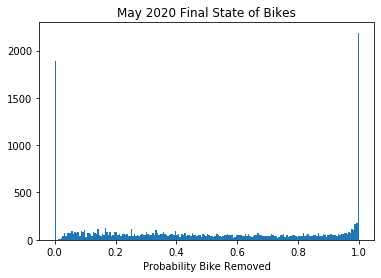

In [50]:
plt.hist(1 - bike_summ.prob_not_selected, bins=np.linspace(0, 1, 201))
#plt.xlim([0, 1])
plt.xlabel('Probability Bike Removed')
plt.title('May 2020 Final State of Bikes')
plt.show()

This chart shows about 2000 bikes have a very high chance of having been removed!

The results show that there are a large number of bikes at 0, which means they were just dropped off

Next, we need to determine a threshold to identify when we are statistically certain that a bike is no longer operational. If we have 15,000 bikes, and we choose a threshold of 1%, then that would mean that on average 150 bikes would be incorrectly flagged as broken. This is a lot, since someone would likely need to travel to each station to determine if a bike was operational. Also, the cost of leaving a broken Citi Bike at a station for a few days too long is fairly small. The main cost is that the station has one fewer operational docks. Therefore I will choose a threshold of 1 in 100,000.

This corresponds to 10^-5 probability of not being selected if all bikes at the station were reandomly selected at the same rate.

In [59]:
num_broken_bikes = len(bike_summ[bike_summ.prob_not_selected < 1e-5])
num_bikes = len(bike_summ)

print('Number Total Bikes : %i' % (num_bikes))
print('Number Broken Bikes : %i' % (num_broken_bikes))
print('Percent Found Broken : %.2f' % (100*num_broken_bikes/num_bikes))

Number Total Bikes : 15003
Number Broken Bikes : 1261
Percent Found Broken : 8.40


Choosing a threshold of 1 in 100,000 means that 8.4% of bikes are declared removed based on our single analysis at the end of the month. It's likely that these bikes were removed since they broke down. This failure rate seems slightly high, but not unreasonably so. Bikes are complex and require routine maintenance, Citi Bikes are used frequently in a harsh environment, and thus may break down at a high rate.


### Continuous Monitoring of Bike Removals / Breakdowns
Right now the analysis is relying on the conditions at the end of the month. It would be much better to run this analysis in real time, every time a bike is selected from a station! This would give continuous insight into which bikes are removed. As soon as we determine a bike is removed, we can remove it from that station.

If this was used to determine which bikes were broken, maintenance teams could be dispatched to determine if the bike is broken.

To continously monitor the status of each bike, we add a check to run each time a bike is not selected. If the probability of being operational is less than our threshold, we declare the bike not operational. At the same time, we record the number of times people selected bikes from this station before it became something is likely wrong with this bike.

In [60]:
class CitiBike(object):
    def __init__(self, id, location, last_drop_off_time):
        self.id = id
        self.location = location
        self.prob_not_selected = 1
        self.consecutive_times_not_selected = 0
        self.last_drop_off_time = last_drop_off_time
        self.operational = True
        self.trials_to_detect_failure = np.nan
        self.time_to_detect_failure = np.nan

    def bike_selected(self):
        self.prob_not_selected = 1
        self.location = 1
        self.consecutive_times_not_selected = 0
        self.operational = True

    def bike_drop_off(self, location, time):
        self.location = location
        self.last_drop_off_time = time
    
    def bike_not_selected(self, bikes_available):
        p = 1/bikes_available
        self.prob_not_selected = self.prob_not_selected*(1 - p)
        self.consecutive_times_not_selected += 1
        
    def remove_from_service(self, time):
        self.operational = False
        self.trials_to_detect_failure = self.consecutive_times_not_selected
        self.time_of_detection = time
        if type(self.last_drop_off_time) is pd.Timestamp:
            self.time_to_detect_failure = time - self.last_drop_off_time

        return (self.id, self.location, time, self.trials_to_detect_failure, self.time_to_detect_failure)

In [88]:
def run_simulation(ops, network, fleet):
    removals = []
    additions = []
    
    for bike_id, station_id, op_type, op_time in ops[ops.op_type!='status'][['bike_id', 'station_id', 'op_type', 'op_time']].values:
        # Get CitiBike and Station objects
        bike = fleet[bike_id]
        station = network[station_id]

        # If departure, bike has been selected, and remove bike station
        if op_type == 'departure':
            num_bikes_available = len(station.bikes)
            bike.bike_selected()
            if bike_id in station.bikes:
                station.remove_bike(bike_id)
            else:
                additions.append((bike_id, station_id, op_time))

            # Increment selection probability of other bikes at this station
            for other_bike_id in station.bikes:
                fleet[other_bike_id].bike_not_selected(num_bikes_available)
                
                # Remove from bike from service
                if fleet[other_bike_id].prob_not_selected < 1e-6:
                    removal_info = fleet[other_bike_id].remove_from_service(op_time)
                    removals.append(removal_info)
            
            # Remove non operational bikes from station
            [station.remove_bike(x) for x in station.bikes if not fleet[x].operational]

        # If arrival, bike has been dropped of, and add bike to station
        elif op_type == 'arrival':
            bike.bike_drop_off(station_id, op_time)
            station.add_bike(bike_id)
    return network, fleet, additions, removals

In [89]:
network, fleet = initialize_network_and_fleet(all_stations, ops)
network, fleet, addition_list, removal_list = run_simulation(ops, network, fleet)

In [90]:
additions = pd.DataFrame(addition_list, columns=['bike_id', 'station_id', 'op_time'])
removals = pd.DataFrame(removal_list, columns=['bike_id', 'station_id', 'removal_time', 'trials_to_detection', 'time_to_detection'])

In [91]:
print(removals.trials_to_detection.mean())
print(removals.time_to_detection.mean())

250.35746961181545
2 days 09:15:27.989584


On average, it takes 2 days and 5 hours without a bike being selected for the algorithm to classify it as not operational. In addition, on average there are 215 removals at the station before the algorithm determines that the bike is broken. This would be significantly shorter than waiting for the whole month to complete before batch processing. This will reduce the amount of time a broken bike takes up a dock, enable faster diagnosis, and improve the number of available bikes.

<img src="citi_bike_crosswalk.jpg" width=600/>

### Add Bicycle Removals and Additions to Operations Dataset
The next step is to use the following method to simulate removals of broken bikes. This will help determine how many bikes are at a given station at any given time.

In [92]:
# Removals
removal_ops = removals.merge(stations[['id', 'stationName']], how='left', left_on='station_id', right_on='id')
removal_ops = removal_ops.rename(columns={'removal_time' : 'op_time', 'stationName': 'station_name'}) \
                      .drop(columns={'trials_to_detection', 'time_to_detection', 'id'})
removal_ops['op_type'] = 'removal'
removal_ops['net_bikes'] = -1
removal_ops['op_time'] = removal_ops['op_time'] + pd.Timedelta(1, 'ms')

# Additions
addition_ops = additions.merge(stations[['id', 'stationName']], how='left', left_on='station_id', right_on='id')
addition_ops = addition_ops.rename(columns={'stationName': 'station_name'}).drop(columns={'id'})
addition_ops['op_type'] = 'addition'
addition_ops['net_bikes'] = 1
addition_ops['op_time'] = addition_ops['op_time'] + pd.Timedelta(1, 'ms')

In [93]:
# Calculate the new number of starting bikes
ops_2 = pd.concat([ops, removal_ops, addition_ops]).sort_values(by='op_time')

ops_2['sum_net_bikes'] = ops_2.groupby('station_id')['net_bikes'].cumsum()

# Calculate the new number of starting bikes
offset_2 = ops_2[ops_2.op_type=='status'][['station_id', 'available_bikes', 'sum_net_bikes']].copy()
offset_2['starting_bikes'] = offset_2['available_bikes'] - offset_2['sum_net_bikes']

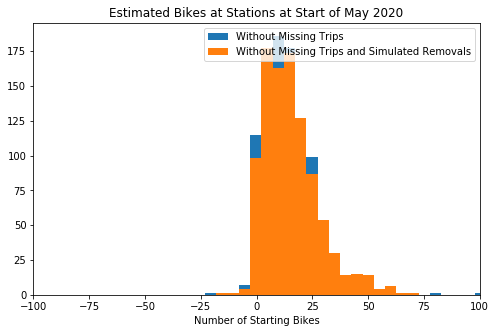

In [94]:
plt.rcParams['figure.figsize'] = 8, 5
plt.hist(offset.starting_bikes, bins=np.linspace(-300, 400, 140), label='Without Missing Trips')
plt.hist(offset_2.starting_bikes, bins=np.linspace(-300, 400, 140), label='Without Missing Trips and Simulated Removals')
plt.xlabel('Number of Starting Bikes')
plt.title('Estimated Bikes at Stations at Start of May 2020')
plt.legend()
plt.xlim([-100, 100])
plt.show()

In [95]:
# Merge the number of total docks
offset_2 = offset_2.merge(stations[['id', 'totalDocks']], how='left', left_on='station_id', right_on='id')

# Get the percent of invalid starting bikes available
print('Percent of invalid starting bikes %.2f ' % (100*np.mean((offset_2.starting_bikes < 0) | (offset_2.starting_bikes > offset_2.totalDocks))))

Percent of invalid starting bikes 5.55 
